In [16]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


# Practica 1: Paralelizacion.

Parte 1: Investigar sobre las lazy variables y como se usa el Delay para problemas mas grandes.

Parte 2: Generen varias funciones y construyan un grafo de paralelización con al menos 4 cuellos de botella.


Extra challenge: Buscar ensemble learning en Scikit learn, utilizar minimo 3 algoritmos de machine learning para crear un modelo paralelo basado en un ensamble. Generar uno con dask y otro con la libreria de ensemble de sklearn, y comparar resultados. 

Las **lazy variables** son una característica presente en ciertos lenguajes de programación, donde los cálculos se retrasan hasta que se requieran sus resultados. En lugar de realizar un cálculo anticipado al encontrar una declaración, se guarda una estructura que describe el cálculo que debe llevarse a cabo cuando se necesita el valor resultante [1].

Un efecto importante de la lazy evaluation es la capacidad de describir y manipular "lazy infinite data structures" (estructuras de datos infinitas perezosas). Estas son estructuras de datos que se comportan como si fueran infinitamente grandes, calculando su contenido solo cuando es necesario.
Un ejemplo de esto se ve en Haskell, donde un tipo de dato simple es el de una "linked list" (lista enlazada). Un objeto de lista enlazada es o bien un par de un valor de cabeza (head value) y una lista de cola (tail list), representado por el operador ":", o la lista vacía, representada por "[]". Por ejemplo, la lista ordenada de enteros positivos menores que cuatro podría ser representada como (1:(2:(3:[]))). Es posible escribir una función que devuelva una lista donde la cola de la lista es el resultado de una llamada a la función misma, como f = (1:f).
En un lenguaje no perezoso, evaluar este programa no terminaría debido a la llamada recursiva infinita a f, pero en un lenguaje perezoso la llamada a la función se realiza solo cuando se necesita la cola de una lista, por lo que esta "lazy infinite list" (lista infinita perezosa) se puede manipular de manera similar a cualquier otra lista [2, 3].

In [ ]:
import dask
import dask.delayed
import time

In [28]:
@dask.delayed
def f(x):
    result = x * 2
    return result

@dask.delayed
def g(x):
    result = x + 5
    return result

@dask.delayed
def h(x):
    result = x ** 3
    return result

@dask.delayed
def i(x):
    result = x - 10
    return result

In [37]:
a = f(999)
b = g(a)
c = h(b)
d = i(c)


# grafo de paralelización
graph = dask.delayed(sum)([a, b, c, d])


In [38]:
%%time

result = graph.compute()

print(result)

16072112045
CPU times: user 2.71 ms, sys: 1.81 ms, total: 4.52 ms
Wall time: 3.28 ms


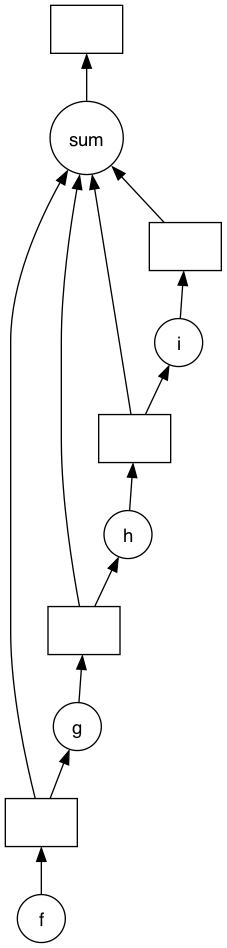

In [36]:
graph.visualize()

In [9]:
# extra

from dask.distributed import Client
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
import timeit

In [13]:
import warnings

warnings.filterwarnings("ignore")


In [6]:
# datos de ejemplo
X, y = make_classification(n_samples=10000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
classifiers = [
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(),
    SVC(probability=True)
]

## Dask

In [24]:
%%time
client = Client()
ensemble_model_dask = VotingClassifier([(classifier.__class__.__name__, classifier) for classifier in classifiers])


with joblib.parallel_backend('dask'):
    ensemble_model_dask.fit(X_train, y_train)
    


CPU times: user 808 ms, sys: 319 ms, total: 1.13 s
Wall time: 4.42 s


## sklearn

In [25]:
%time
ensemble_model_sklearn = VotingClassifier([(classifier.__class__.__name__, classifier) for classifier in classifiers])
ensemble_model_sklearn.fit(X_train, y_train)



CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 7.87 µs


VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('LogisticRegression', LogisticRegression()),
                             ('SVC', SVC(probability=True))])

## En resumen, Dask tuvo un tiempo de ejecución total de 1.13 seg y un tiempo de ejecución en tiempo real (wall time) de 4.42 seg. Por otro lado, Scikit-learn tuvo un tiempo de ejecución total de 5 microsegundos y un tiempo de ejecución en tiempo real de 7 µs.


[1] John Daintith and Edmund Wright. A Dictionary of Computing: lazy evaluation. http://www.oxfordreference.com/10.1093/acref/9780199234004.
001.0001/acref-9780199234004-e-2850 

[2] Miran Lipovaca. Learn you a haskell for great good!: a beginner’s guide. no
starch press, 2011.

[3] Bryan O’Sullivan, John Goerzen, and Donald Bruce Stewart. Real world
haskell: Code you can believe in. ” O’Reilly Media, Inc.”, 2008.